<a href="https://colab.research.google.com/github/FayAlsalhi/Deep-neural-stylization-model/blob/main/Deep_neural_stylization_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

⬇️ جاري تحميل داتاست Landscape Pictures من كاغل...
Using Colab cache for faster access to the 'landscape-pictures' dataset.
📁 تم التحميل بنجاح. المسار:
/kaggle/input/landscape-pictures
🔁 جاري نسخ الصور إلى مجلد data/content/_ ...
✅ تم نسخ 4319 صورة بنجاح إلى data/content/_
🖼️ عدد الصور الجاهزة: 4319


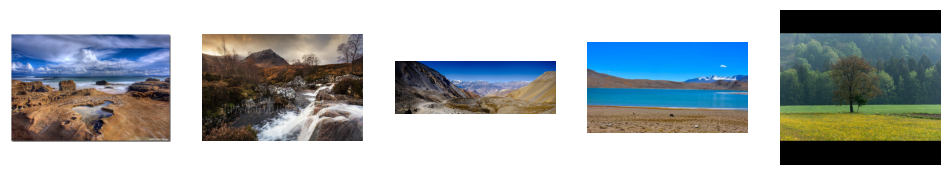

✨ الداتاست جاهزة تمامًا لبدء التدريب.


In [ ]:

!pip install -q kagglehub

import kagglehub
import os, shutil
from pathlib import Path


print("⬇️ Landscape Pictures ")
path = kagglehub.dataset_download("arnaud58/landscape-pictures")
print("📁 تم التحميل بنجاح. :")
print(path)


os.makedirs("data/content/_", exist_ok=True)
os.makedirs("styles", exist_ok=True)
os.makedirs("outputs", exist_ok=True)





dst = "data/content/_"
valid_exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
copied = 0

for p in Path(path).rglob("*"):
    if p.suffix.lower() in valid_exts:
        shutil.copy2(p, os.path.join(dst, p.name))
        copied += 1

print(f"✅ تم نسخ {copied} صورة بنجاح إلى {dst}")


imgs = list(Path("data/content/_").rglob("*"))
print("🖼️ عدد الصور الجاهزة:", len(imgs))


import random
import matplotlib.pyplot as plt
from PIL import Image

sample = random.sample(imgs, 5)
plt.figure(figsize=(12,3))
for i, p in enumerate(sample):
    plt.subplot(1,5,i+1)
    plt.imshow(Image.open(p))
    plt.axis("off")
plt.show()

print("✨ dataset جاهزة تمامًا لبدء التدريب.")

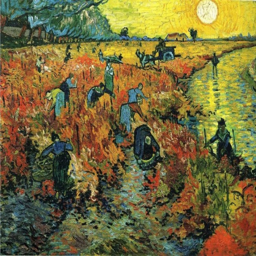

جاهز: styles/style.jpg


In [ ]:
from PIL import Image
from pathlib import Path
from PIL import ImageFilter

p = Path("styles/style.jpeg")
if p.exists():
    display(Image.open(p).resize((256, 256)))
    print("جاهز: styles/style.jpg")
else:
    print("ما وُجد الملف: ")

In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import random, os


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
IMG_SIZE = 256
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [ ]:



vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features.to(device).eval()
for p in vgg.parameters():
    p.requires_grad_(False)


content_layer = '21'
style_layers  = ['0','5','10','19','28']


def extract_feats(x):
    feats, h = {}, x
    for name, layer in vgg._modules.items():
        h = layer(h)
        if name == content_layer:
            feats['content'] = h
        if name in style_layers:
            feats[name] = h
    return feats

def gram_matrix(fm):

    b, c, h, w = fm.shape
    features = fm.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

style_img = Image.open("styles/style.jpeg").convert("RGB")
style_t   = transform(style_img).unsqueeze(0).to(device)

with torch.no_grad():
    s_feats = extract_feats(style_t)
    s_grams = {k: gram_matrix(v) for k, v in s_feats.items() if k in style_layers}

print("🎨 جاهزين بأسلوب واحد ✔️")

Device: cuda
🎨 جاهزين بأسلوب واحد ✔️


In [ ]:
from torch.utils.data import DataLoader, Dataset

class FlatImageFolder(Dataset):
    def __init__(self, root, transform=None, exts=(".jpg",".jpeg",".png",".bmp",".webp")):
        self.root = Path(root)
        self.transform = transform
        self.paths = [p for p in self.root.rglob("*") if p.suffix.lower() in exts]
        if len(self.paths) == 0:
            raise RuntimeError("⚠️ لا توجد صور داخل data/content/_")
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, 0

train_set = FlatImageFolder("data/content/_", transform=transform)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=0)
print("✅ تم تحميل الداتا بنجاح، عدد الصور:", len(train_set))

✅ تم تحميل الداتا بنجاح، عدد الصور: 4319


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(c, c, 3, 1, 1), nn.InstanceNorm2d(c), nn.ReLU(inplace=True),
            nn.Conv2d(c, c, 3, 1, 1), nn.InstanceNorm2d(c)
        )
    def forward(self, x):
        return x + self.block(x)

class StyleTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 9, 1, 4),  nn.InstanceNorm2d(32),  nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 2, 1), nn.InstanceNorm2d(64),  nn.ReLU(inplace=True),
            nn.Conv2d(64, 128,3, 2, 1), nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
            ResidualBlock(128), ResidualBlock(128), ResidualBlock(128),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(128, 64, 3, 1, 1), nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, 3, 1, 1),  nn.InstanceNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 9, 1, 4)
        )
    def forward(self, x):
        return self.net(x)


net = StyleTransformer().to(device)
print("✅ تم إنشاء الموديل بنجاح:", type(net).__name__)

✅ تم إنشاء الموديل بنجاح: StyleTransformer


In [ ]:

import os, torch

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
alpha, beta, tv_w = 1.0, 700.0, 1e-6
EPOCHS = 5



# مجلد الحفظ
check_dir = "outputs/checkpoints"
os.makedirs(check_dir, exist_ok=True)

checkpoints = [f for f in os.listdir(check_dir) if f.endswith(".pth")]
if checkpoints:
    latest_ckpt = sorted(checkpoints, key=lambda x: int(x.split("_")[1].split(".")[0]))[-1]
    checkpoint_path = os.path.join(check_dir, latest_ckpt)
    print(f"🔄 جاري تحميل آخر نقطة تدريب: {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"]
    print(f"✅ تم التحميل! سنكمل من الإيبوك رقم {start_epoch+1}")
else:
    print("🚀 لا توجد نقاط تدريب محفوظة، سنبدأ من الصفر.")
    start_epoch = 0



def tv_loss(x):
    return torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) + \
           torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))


checkpoint_path = "outputs/checkpoints/epoch_5.pth"

start_epoch = 0
if os.path.exists(checkpoint_path):
    print(f"🔄 جاري تحميل نقطة التدريب: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    start_epoch = checkpoint["epoch"]
    print(f"✅ تم التحميل! سنكمل من الإيبوك رقم {start_epoch+1}")
else:
    print("🚀 لا توجد نقطة تدريب محفوظة، سنبدأ من الصفر.")


for epoch in range(start_epoch, EPOCHS):
    net.train()
    running_loss = 0.0

    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        out = net(imgs)

        g_feats = extract_feats(out)
        c_feats = extract_feats(imgs)


        c_loss = F.mse_loss(g_feats['content'], c_feats['content'])

        s_loss = 0
        for k in style_layers:
            g = gram_matrix(g_feats[k])
            s = s_grams[k].repeat(g.size(0), 1, 1)
            s_loss += F.mse_loss(g, s)


        loss = alpha*c_loss + beta*s_loss + tv_w*tv_loss(out)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}")

    if (epoch + 1) % 3 == 0:
        checkpoint_path = f"outputs/checkpoints/epoch_{epoch+1}.pth"
        torch.save({
            "epoch": epoch + 1,
            "model_state": net.state_dict(),
            "optimizer_state": optimizer.state_dict(),
        }, checkpoint_path)
        print(f"✅ تم حفظ التقدم في: {checkpoint_path}")

🚀 لا توجد نقاط تدريب محفوظة، سنبدأ من الصفر.
🚀 لا توجد نقطة تدريب محفوظة، سنبدأ من الصفر.
Epoch 1/5 - Loss: 0.6860
Epoch 2/5 - Loss: 0.3877
Epoch 3/5 - Loss: 0.2963
✅ تم حفظ التقدم في: outputs/checkpoints/epoch_3.pth
Epoch 4/5 - Loss: 0.2446
Epoch 5/5 - Loss: 0.2207


🖼️ تم اختيار الصورة: 00000641_(2).jpg


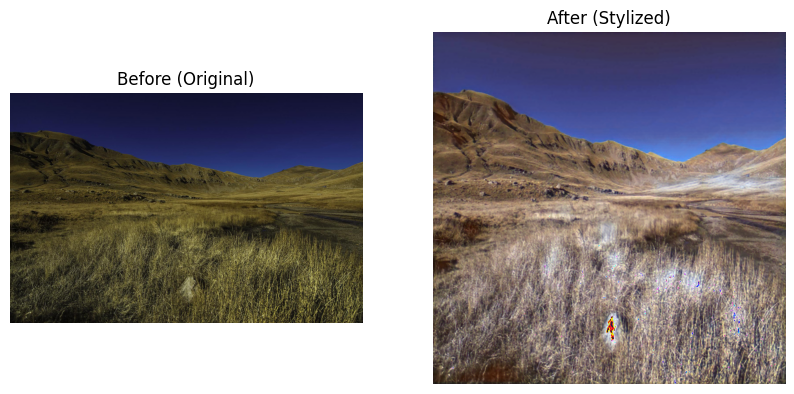

✅ تم حفظ الصورة في: outputs/stylized_result.jpg


In [ ]:


from PIL import ImageFilter


folder_path = "data/content/_/"


all_images = [f for f in os.listdir(folder_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
if not all_images:
    raise FileNotFoundError("❌ ما فيه صور في المجلد data/content/_/ !")

test_path = os.path.join(folder_path, random.choice(all_images))
out_path = "outputs/stylized_result.jpg"

print(f"🖼️ تم اختيار الصورة: {os.path.basename(test_path)}")


content_img = Image.open(test_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((720, 720)),
    transforms.ToTensor(),
])
content_tensor = transform(content_img).unsqueeze(0).to(device)


net.eval()
with torch.no_grad():
    stylized_output = net(content_tensor)


out_img = transforms.ToPILImage()(stylized_output.squeeze().cpu())

out_img = out_img.filter(ImageFilter.ModeFilter(size=3))


out_img.save(out_path)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.set_title("Before (Original)")
ax1.imshow(content_img)
ax1.axis("off")

ax2.set_title("After (Stylized)")
ax2.imshow(out_img)
ax2.axis("off")

plt.show()
print(f"✅ تم حفظ الصورة في: {out_path}")